In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

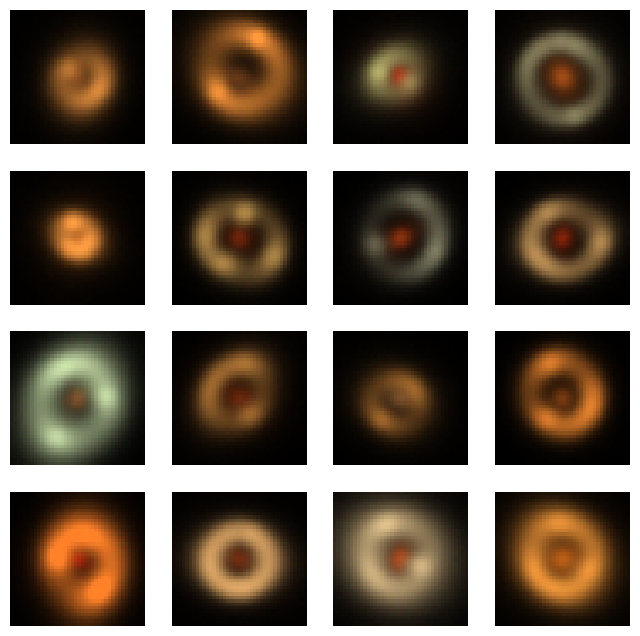

In [4]:
# Visualize source data
visualize_data(source_data)

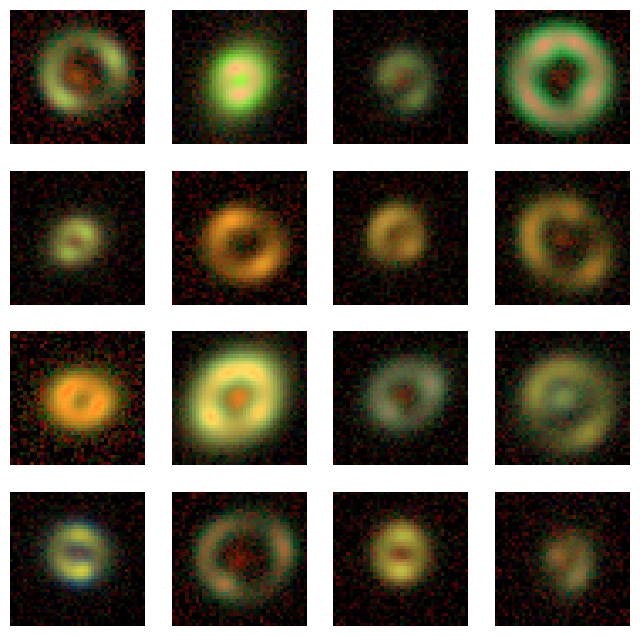

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    if epoch < evolv_epoch:
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / evolv_epoch))
    else:
        da_weight = final_wt_da
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    else:
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5

n_epoch = 250
evolv_epoch = 150

beta_init = 1.0
beta_final = 0.5

init_wt_da = 1.4
final_wt_da = 1.0

In [7]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = MultiStepLR(optimizer, milestones=[100, 200, 250, 275], gamma=0.5)

In [8]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v2_aug24_1205"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


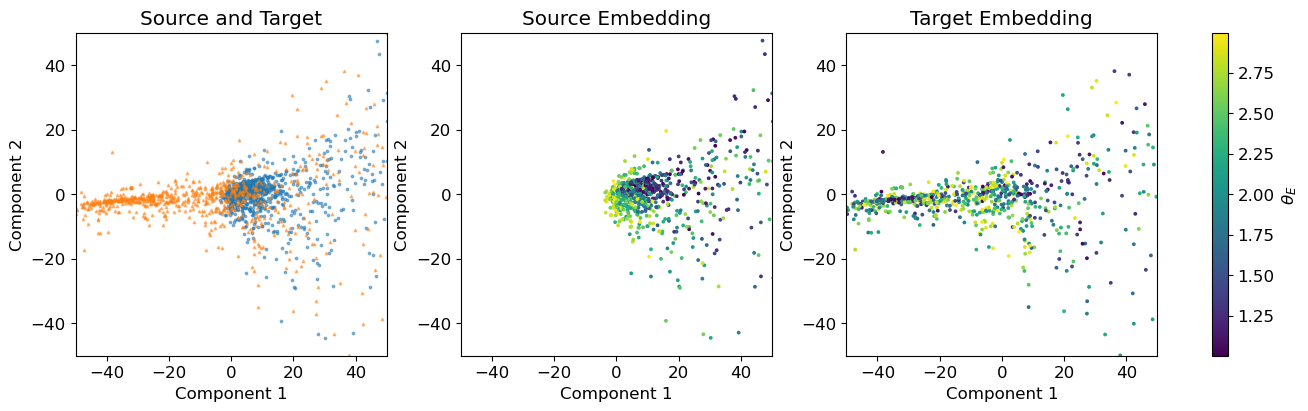


Epoch 0: 40.08s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4657
	Train Regression Loss: : 2.0740
	Train Mve Loss: : 0.8835
	Train R2 Score: : -5.3215
 Validation Statistics:
	Val Source Regression Loss: : 0.7792
	Val Target Regression Loss: : 0.7237
	Val Source R2 Score: : -1.3843
	Val Target R2 Score: : -1.1479
	Val Source Mve Loss: : 0.2336
	Val Target Mve Loss: : 0.2026
	Val Source Nll Loss: : 0.4683
	Val Target Nll Loss: : 0.4784
Saving Model MVE... Done.
Saving Model NLL... Done.

Epoch 1: 35.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3154
	Train Regression Loss: : 0.4476
	Train Mve Loss: : 0.0647
	Train R2 Score: : -0.3531
 Validation Statistics:
	Val Source Regression Loss: : 0.2847
	Val Target Regression Loss: : 0.2972
	Val Source R2 Score: : 0.1322
	Val Target R2 Score: : 0.1142
	Val Source Mve Loss: : -0.0216
	Val Target Mve Loss: : -0.0199
	Val Source Nll Loss: : -0.0725
	Val Target Nll Loss: : -0.0428
Saving

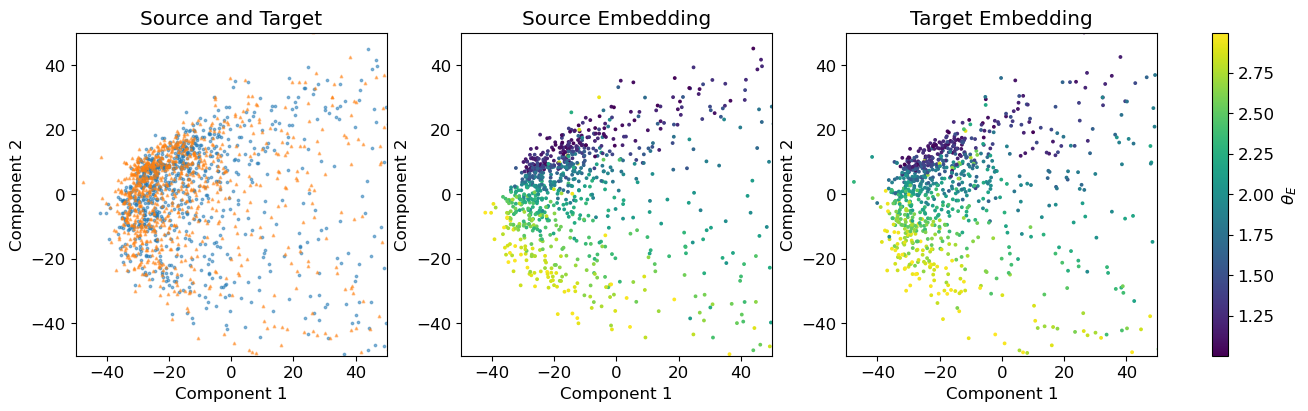

Saving Model... Done.

Epoch 20: 36.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0310
	Train Regression Loss: : 0.0179
	Train Mve Loss: : -0.0536
	Train R2 Score: : 0.9459
 Validation Statistics:
	Val Source Regression Loss: : 0.0181
	Val Target Regression Loss: : 0.0235
	Val Source R2 Score: : 0.9445
	Val Target R2 Score: : 0.9297
	Val Source Mve Loss: : -0.0409
	Val Target Mve Loss: : -0.0414
	Val Source Nll Loss: : 6408.8970
	Val Target Nll Loss: : 7458.6264
Saving Model... Done.

Epoch 21: 37.02s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0297
	Train Regression Loss: : 0.0172
	Train Mve Loss: : -0.0875
	Train R2 Score: : 0.9479
 Validation Statistics:
	Val Source Regression Loss: : 0.0175
	Val Target Regression Loss: : 0.0236
	Val Source R2 Score: : 0.9463
	Val Target R2 Score: : 0.9298
	Val Source Mve Loss: : -0.0829
	Val Target Mve Loss: : -0.0821
	Val Source Nll Loss: : 6109.2496
	Val Target Nll Loss: : 6696.6275
Sa

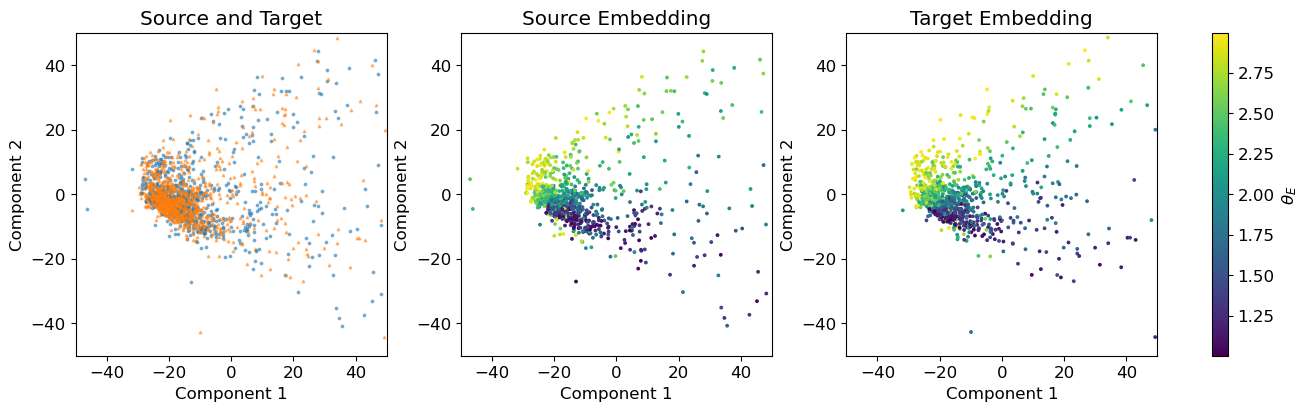


Epoch 40: 37.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0231
	Train Regression Loss: : 0.0149
	Train Mve Loss: : -0.1117
	Train R2 Score: : 0.9547
 Validation Statistics:
	Val Source Regression Loss: : 0.0147
	Val Target Regression Loss: : 0.0208
	Val Source R2 Score: : 0.9550
	Val Target R2 Score: : 0.9384
	Val Source Mve Loss: : -0.1474
	Val Target Mve Loss: : -0.1429
	Val Source Nll Loss: : 33.1217
	Val Target Nll Loss: : 52.1637

Epoch 41: 40.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0229
	Train Regression Loss: : 0.0146
	Train Mve Loss: : -0.1052
	Train R2 Score: : 0.9558
 Validation Statistics:
	Val Source Regression Loss: : 0.0146
	Val Target Regression Loss: : 0.0202
	Val Source R2 Score: : 0.9553
	Val Target R2 Score: : 0.9400
	Val Source Mve Loss: : -0.0827
	Val Target Mve Loss: : -0.0764
	Val Source Nll Loss: : 2837.9943
	Val Target Nll Loss: : 5082.6238

Epoch 42: 39.70s
-------------------------------


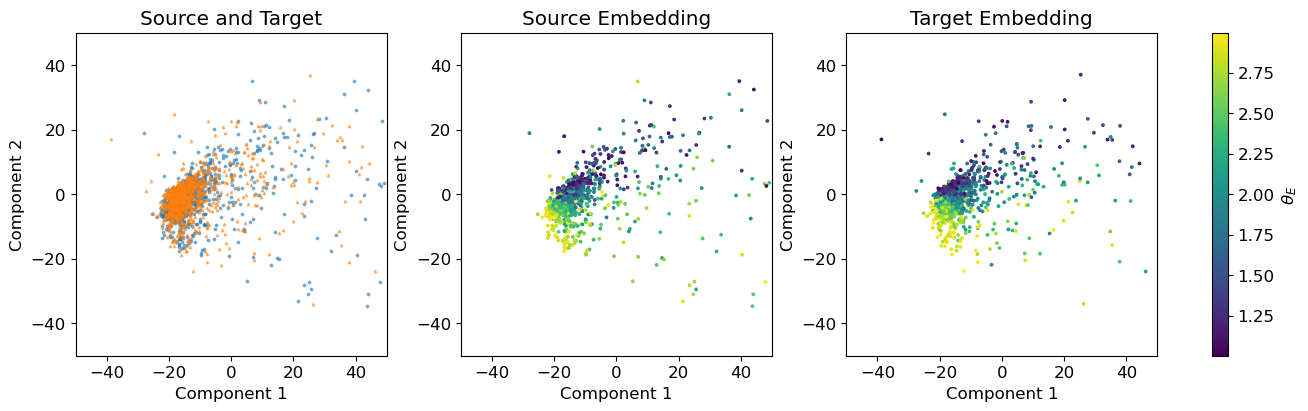


Epoch 60: 38.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0199
	Train Regression Loss: : 0.0120
	Train Mve Loss: : -0.0737
	Train R2 Score: : 0.9635
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.0162
	Val Source R2 Score: : 0.9638
	Val Target R2 Score: : 0.9515
	Val Source Mve Loss: : -0.0646
	Val Target Mve Loss: : -0.0625
	Val Source Nll Loss: : 1593.4496
	Val Target Nll Loss: : 2717.9705
Saving Model... Done.

Epoch 61: 38.02s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0192
	Train Regression Loss: : 0.0120
	Train Mve Loss: : -0.0678
	Train R2 Score: : 0.9636
 Validation Statistics:
	Val Source Regression Loss: : 0.0117
	Val Target Regression Loss: : 0.0181
	Val Source R2 Score: : 0.9641
	Val Target R2 Score: : 0.9458
	Val Source Mve Loss: : -0.0621
	Val Target Mve Loss: : -0.0481
	Val Source Nll Loss: : 785.9410
	Val Target Nll Loss: : 5578.9795

Epoch 62: 35.65s
-------

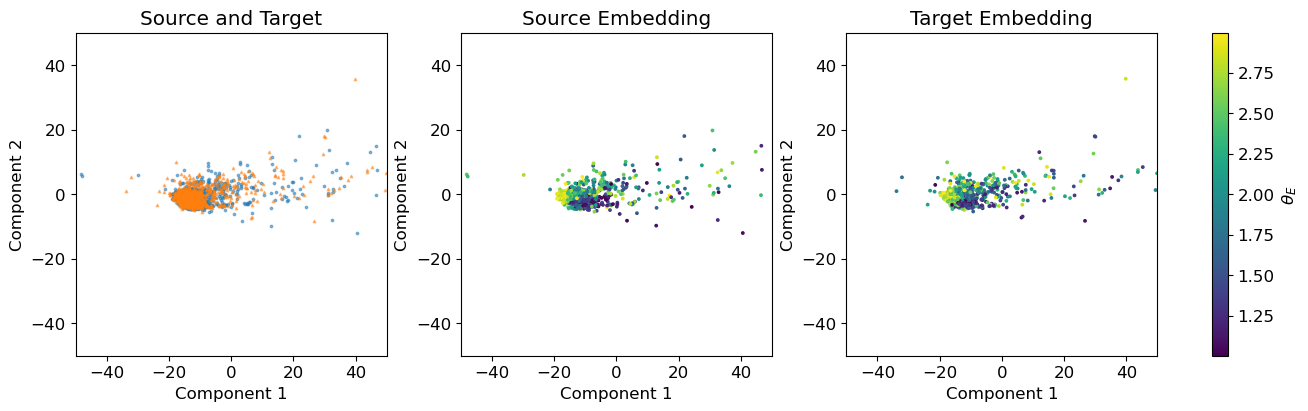


Epoch 80: 38.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0155
	Train Regression Loss: : 0.0117
	Train Mve Loss: : -0.1029
	Train R2 Score: : 0.9643
 Validation Statistics:
	Val Source Regression Loss: : 0.0116
	Val Target Regression Loss: : 0.0172
	Val Source R2 Score: : 0.9642
	Val Target R2 Score: : 0.9482
	Val Source Mve Loss: : -0.0660
	Val Target Mve Loss: : -0.0591
	Val Source Nll Loss: : 944.5729
	Val Target Nll Loss: : 1843.4386

Epoch 81: 38.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0148
	Train Regression Loss: : 0.0125
	Train Mve Loss: : -0.1648
	Train R2 Score: : 0.9622
 Validation Statistics:
	Val Source Regression Loss: : 0.0119
	Val Target Regression Loss: : 0.0190
	Val Source R2 Score: : 0.9633
	Val Target R2 Score: : 0.9440
	Val Source Mve Loss: : -0.1955
	Val Target Mve Loss: : -0.1748
	Val Source Nll Loss: : 798.7426
	Val Target Nll Loss: : 2472.4994

Epoch 82: 38.30s
------------------------------

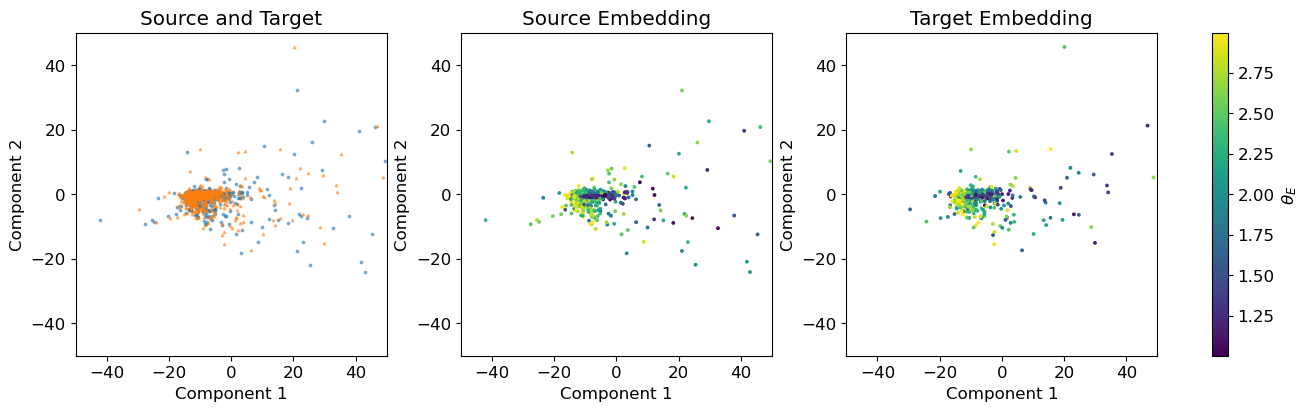


Epoch 100: 36.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0132
	Train Regression Loss: : 0.0105
	Train Mve Loss: : -0.1190
	Train R2 Score: : 0.9683
 Validation Statistics:
	Val Source Regression Loss: : 0.0106
	Val Target Regression Loss: : 0.0164
	Val Source R2 Score: : 0.9673
	Val Target R2 Score: : 0.9514
	Val Source Mve Loss: : -0.0979
	Val Target Mve Loss: : -0.0839
	Val Source Nll Loss: : 135.4785
	Val Target Nll Loss: : 699.0420

Epoch 101: 38.77s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0128
	Train Regression Loss: : 0.0103
	Train Mve Loss: : -0.0978
	Train R2 Score: : 0.9688
 Validation Statistics:
	Val Source Regression Loss: : 0.0103
	Val Target Regression Loss: : 0.0191
	Val Source R2 Score: : 0.9683
	Val Target R2 Score: : 0.9435
	Val Source Mve Loss: : -0.1527
	Val Target Mve Loss: : -0.1332
	Val Source Nll Loss: : 23.8077
	Val Target Nll Loss: : 442.0958

Epoch 102: 38.94s
------------------------------

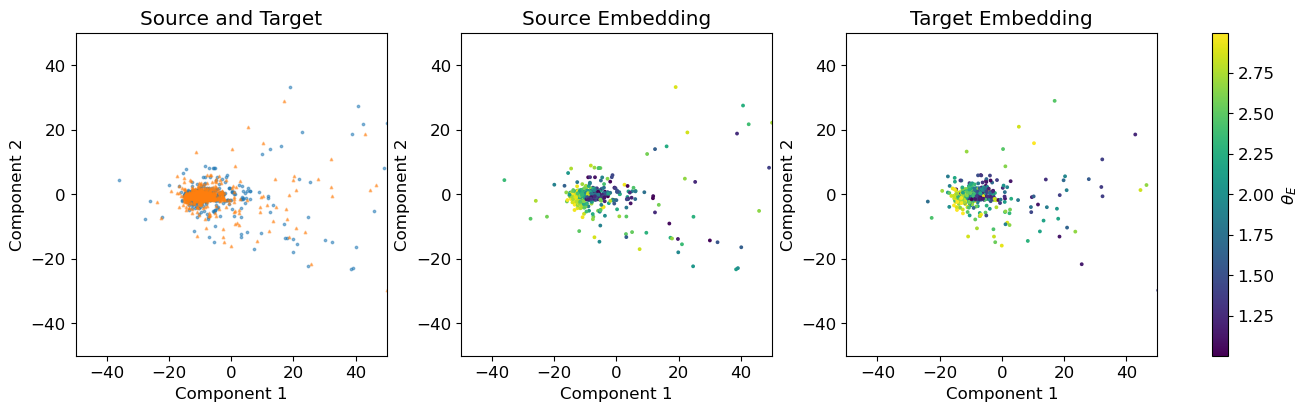

Saving Model NLL... Done.

Epoch 120: 37.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0119
	Train Regression Loss: : 0.0102
	Train Mve Loss: : -0.2059
	Train R2 Score: : 0.9692
 Validation Statistics:
	Val Source Regression Loss: : 0.0101
	Val Target Regression Loss: : 0.0152
	Val Source R2 Score: : 0.9686
	Val Target R2 Score: : 0.9549
	Val Source Mve Loss: : -0.1771
	Val Target Mve Loss: : -0.1757
	Val Source Nll Loss: : 14.4092
	Val Target Nll Loss: : 67.6377
Saving Model... Done.

Epoch 121: 38.16s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0119
	Train Regression Loss: : 0.0098
	Train Mve Loss: : -0.1659
	Train R2 Score: : 0.9703
 Validation Statistics:
	Val Source Regression Loss: : 0.0100
	Val Target Regression Loss: : 0.0152
	Val Source R2 Score: : 0.9693
	Val Target R2 Score: : 0.9546
	Val Source Mve Loss: : -0.1283
	Val Target Mve Loss: : -0.0992
	Val Source Nll Loss: : 314.8114
	Val Target Nll Loss: : 712.4629

E

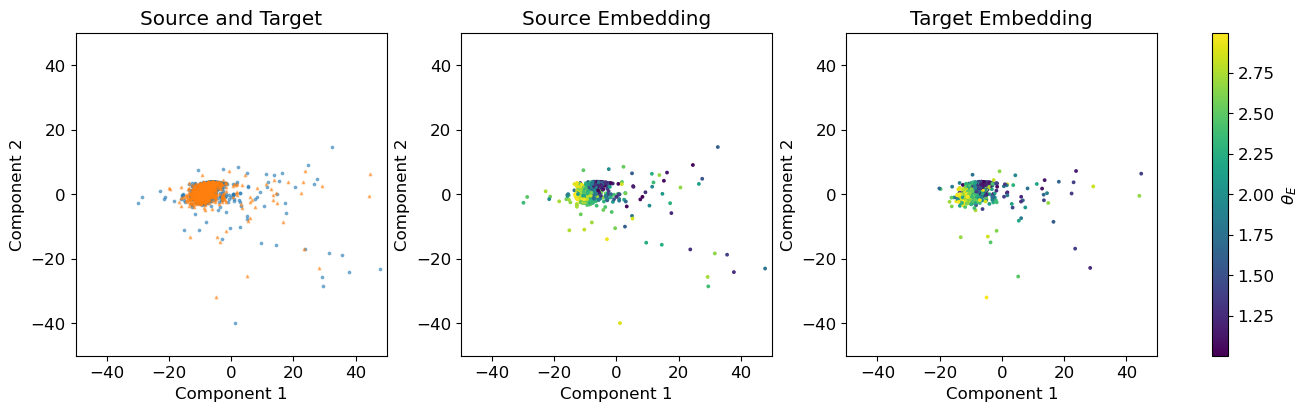


Epoch 140: 40.59s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0109
	Train Regression Loss: : 0.0106
	Train Mve Loss: : -0.2810
	Train R2 Score: : 0.9679
 Validation Statistics:
	Val Source Regression Loss: : 0.0104
	Val Target Regression Loss: : 0.0159
	Val Source R2 Score: : 0.9678
	Val Target R2 Score: : 0.9495
	Val Source Mve Loss: : -0.2678
	Val Target Mve Loss: : -0.1441
	Val Source Nll Loss: : 45.3021
	Val Target Nll Loss: : 664.4885

Epoch 141: 38.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0111
	Train Regression Loss: : 0.0106
	Train Mve Loss: : -0.2134
	Train R2 Score: : 0.9679
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.0192
	Val Source R2 Score: : 0.9635
	Val Target R2 Score: : 0.9427
	Val Source Mve Loss: : -0.3238
	Val Target Mve Loss: : 0.2697
	Val Source Nll Loss: : 10.7069
	Val Target Nll Loss: : 2994.0029

Epoch 142: 38.85s
-------------------------------

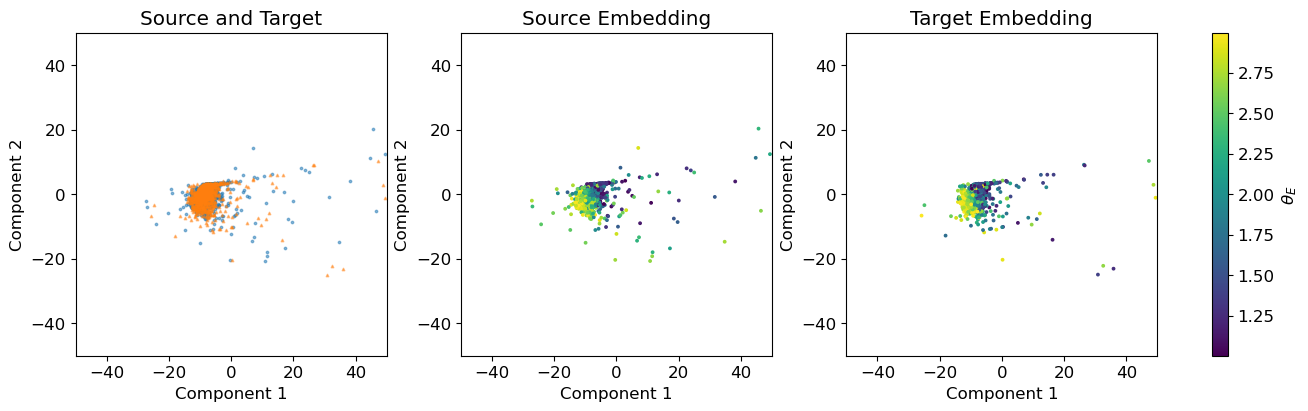


Epoch 160: 37.27s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0112
	Train Regression Loss: : 0.0104
	Train Mve Loss: : -0.3306
	Train R2 Score: : 0.9686
 Validation Statistics:
	Val Source Regression Loss: : 0.0100
	Val Target Regression Loss: : 0.0170
	Val Source R2 Score: : 0.9695
	Val Target R2 Score: : 0.9476
	Val Source Mve Loss: : -0.3416
	Val Target Mve Loss: : -0.2079
	Val Source Nll Loss: : -1.1452
	Val Target Nll Loss: : 380.2888

Epoch 161: 39.70s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0106
	Train Regression Loss: : 0.0098
	Train Mve Loss: : -0.3360
	Train R2 Score: : 0.9701
 Validation Statistics:
	Val Source Regression Loss: : 0.0096
	Val Target Regression Loss: : 0.0166
	Val Source R2 Score: : 0.9707
	Val Target R2 Score: : 0.9509
	Val Source Mve Loss: : -0.3294
	Val Target Mve Loss: : 0.9732
	Val Source Nll Loss: : -1.2613
	Val Target Nll Loss: : 4068.9462

Epoch 162: 38.75s
-------------------------------

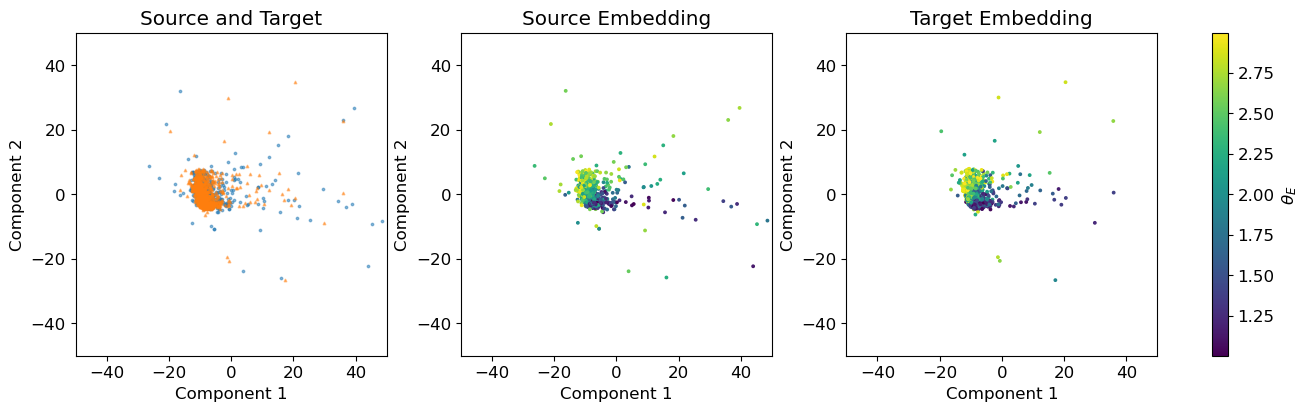


Epoch 180: 38.01s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0101
	Train Regression Loss: : 0.0113
	Train Mve Loss: : -0.3415
	Train R2 Score: : 0.9658
 Validation Statistics:
	Val Source Regression Loss: : 0.0110
	Val Target Regression Loss: : 0.0178
	Val Source R2 Score: : 0.9666
	Val Target R2 Score: : 0.9464
	Val Source Mve Loss: : -0.2881
	Val Target Mve Loss: : 0.6674
	Val Source Nll Loss: : 192.7327
	Val Target Nll Loss: : 3187.9965

Epoch 181: 38.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0108
	Train Regression Loss: : 0.0106
	Train Mve Loss: : -0.3406
	Train R2 Score: : 0.9679
 Validation Statistics:
	Val Source Regression Loss: : 0.0103
	Val Target Regression Loss: : 0.0178
	Val Source R2 Score: : 0.9685
	Val Target R2 Score: : 0.9480
	Val Source Mve Loss: : -0.3285
	Val Target Mve Loss: : 2.5656
	Val Source Nll Loss: : 63.6614
	Val Target Nll Loss: : 9190.2391

Epoch 182: 38.18s
------------------------------

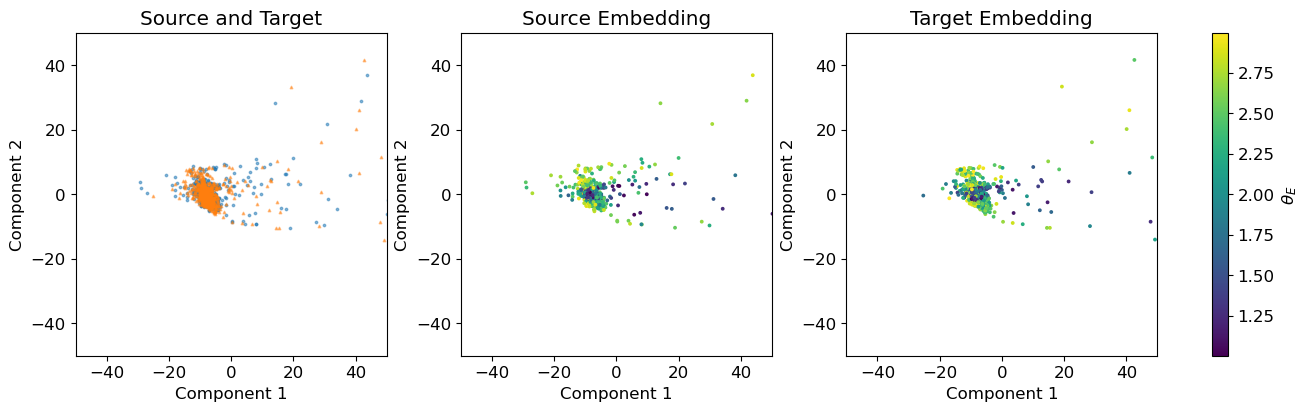


Epoch 200: 38.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0102
	Train Regression Loss: : 0.0106
	Train Mve Loss: : -0.2758
	Train R2 Score: : 0.9679
 Validation Statistics:
	Val Source Regression Loss: : 0.0103
	Val Target Regression Loss: : 0.0196
	Val Source R2 Score: : 0.9685
	Val Target R2 Score: : 0.9416
	Val Source Mve Loss: : -0.2970
	Val Target Mve Loss: : 4.9483
	Val Source Nll Loss: : 157.6551
	Val Target Nll Loss: : 16715.9384

Epoch 201: 38.62s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0105
	Train Regression Loss: : 0.0101
	Train Mve Loss: : -0.2856
	Train R2 Score: : 0.9693
 Validation Statistics:
	Val Source Regression Loss: : 0.0097
	Val Target Regression Loss: : 0.0165
	Val Source R2 Score: : 0.9703
	Val Target R2 Score: : 0.9510
	Val Source Mve Loss: : -0.2718
	Val Target Mve Loss: : 1.1240
	Val Source Nll Loss: : 225.6179
	Val Target Nll Loss: : 4605.1150

Epoch 202: 36.72s
----------------------------

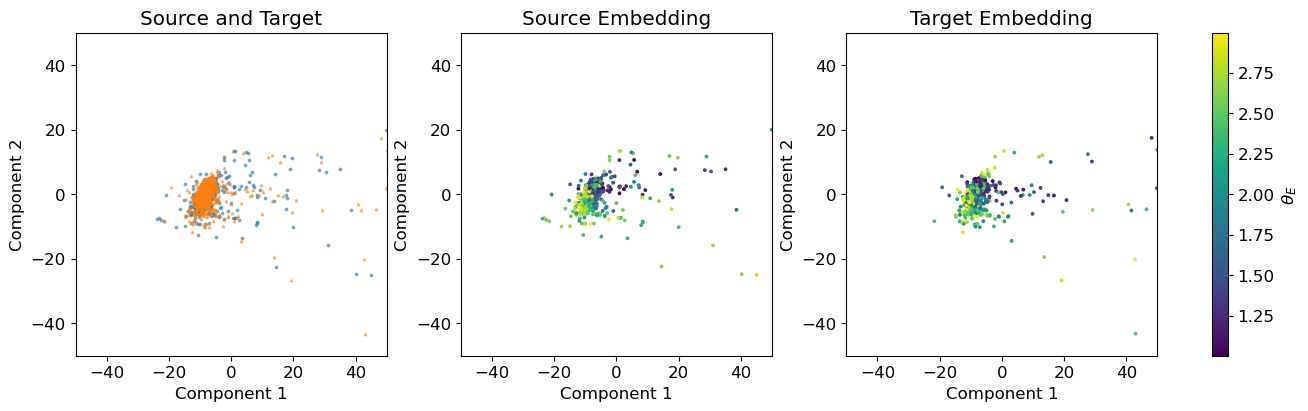


Epoch 220: 40.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0100
	Train Regression Loss: : 0.0103
	Train Mve Loss: : -0.2634
	Train R2 Score: : 0.9690
 Validation Statistics:
	Val Source Regression Loss: : 0.0111
	Val Target Regression Loss: : 0.0197
	Val Source R2 Score: : 0.9663
	Val Target R2 Score: : 0.9408
	Val Source Mve Loss: : -0.3502
	Val Target Mve Loss: : 1.5311
	Val Source Nll Loss: : -1.0005
	Val Target Nll Loss: : 5907.8484

Epoch 221: 37.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0102
	Train Regression Loss: : 0.0100
	Train Mve Loss: : -0.3458
	Train R2 Score: : 0.9696
 Validation Statistics:
	Val Source Regression Loss: : 0.0093
	Val Target Regression Loss: : 0.0185
	Val Source R2 Score: : 0.9716
	Val Target R2 Score: : 0.9450
	Val Source Mve Loss: : -0.3242
	Val Target Mve Loss: : 2.4125
	Val Source Nll Loss: : 33.9929
	Val Target Nll Loss: : 8642.1707

Epoch 222: 39.05s
-------------------------------

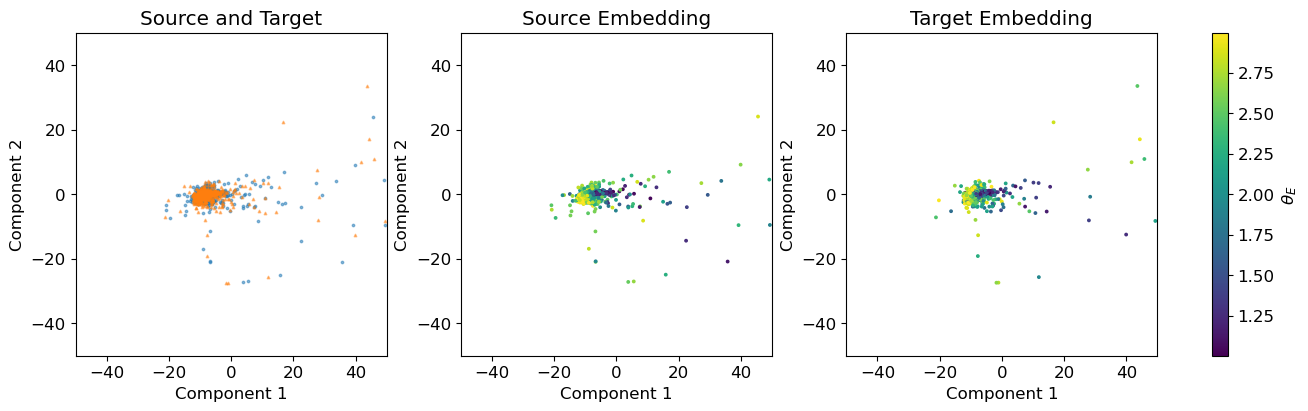


Epoch 240: 38.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0095
	Train Regression Loss: : 0.0091
	Train Mve Loss: : -0.2336
	Train R2 Score: : 0.9725
 Validation Statistics:
	Val Source Regression Loss: : 0.0092
	Val Target Regression Loss: : 0.0150
	Val Source R2 Score: : 0.9716
	Val Target R2 Score: : 0.9535
	Val Source Mve Loss: : -0.2586
	Val Target Mve Loss: : 1.0460
	Val Source Nll Loss: : 29.6575
	Val Target Nll Loss: : 4153.8997

Epoch 241: 36.69s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0101
	Train Regression Loss: : 0.0090
	Train Mve Loss: : -0.2402
	Train R2 Score: : 0.9727
 Validation Statistics:
	Val Source Regression Loss: : 0.0092
	Val Target Regression Loss: : 0.0155
	Val Source R2 Score: : 0.9712
	Val Target R2 Score: : 0.9531
	Val Source Mve Loss: : -0.2327
	Val Target Mve Loss: : 0.3089
	Val Source Nll Loss: : 21.5523
	Val Target Nll Loss: : 1733.9702

Epoch 242: 37.97s
-------------------------------

In [9]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        #scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [10]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [28]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

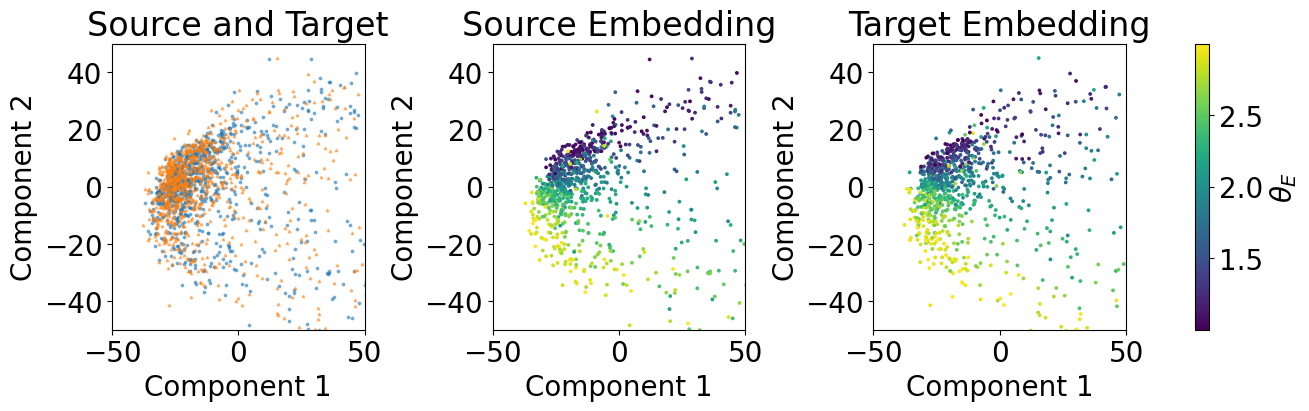

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [29]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

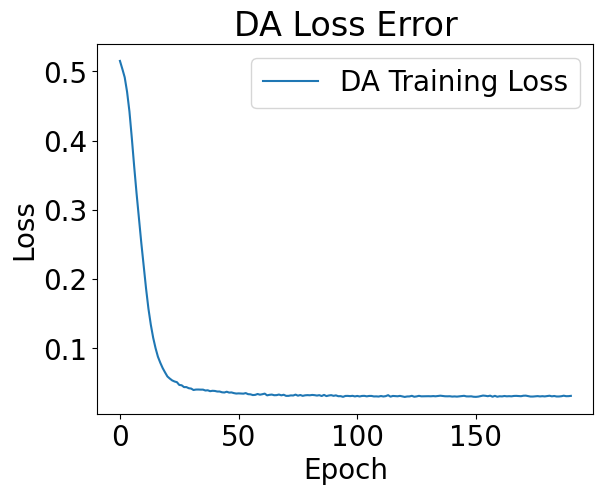

In [30]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

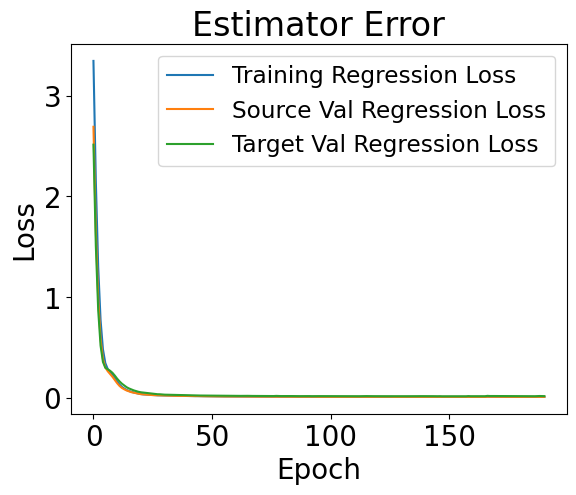

In [31]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

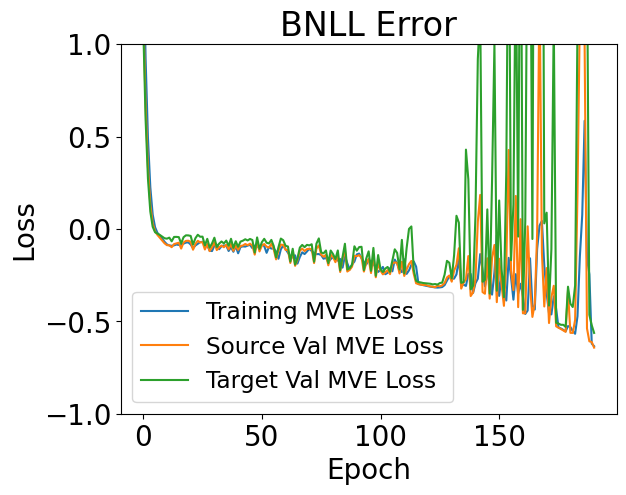

In [32]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

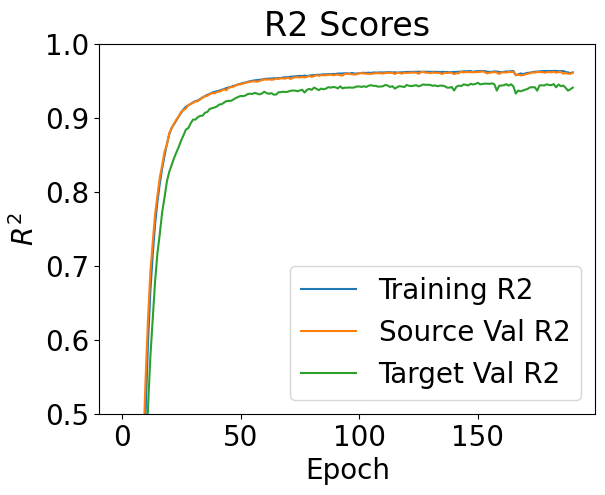

In [33]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [34]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9613


Text(0.5, 1.0, 'MMD | Source | R2: 0.961')

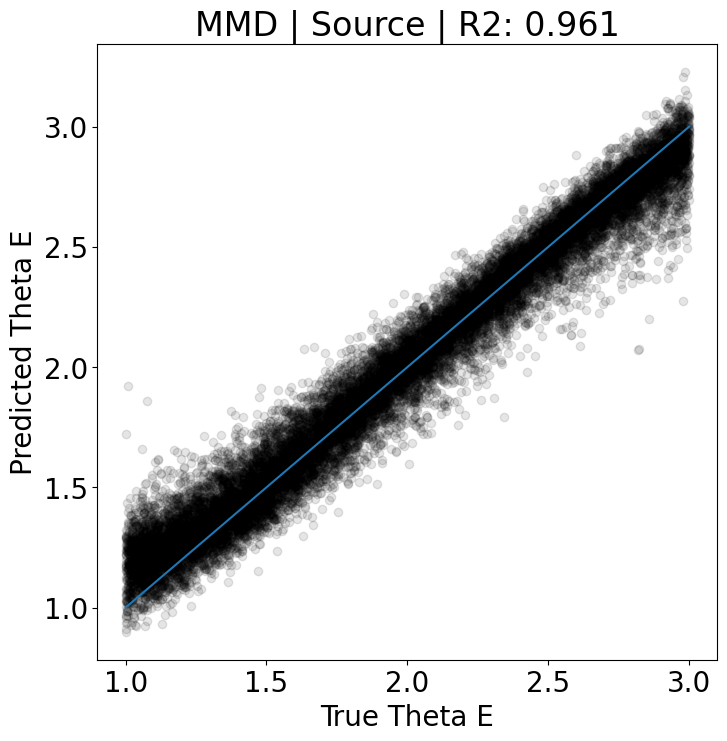

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.308')

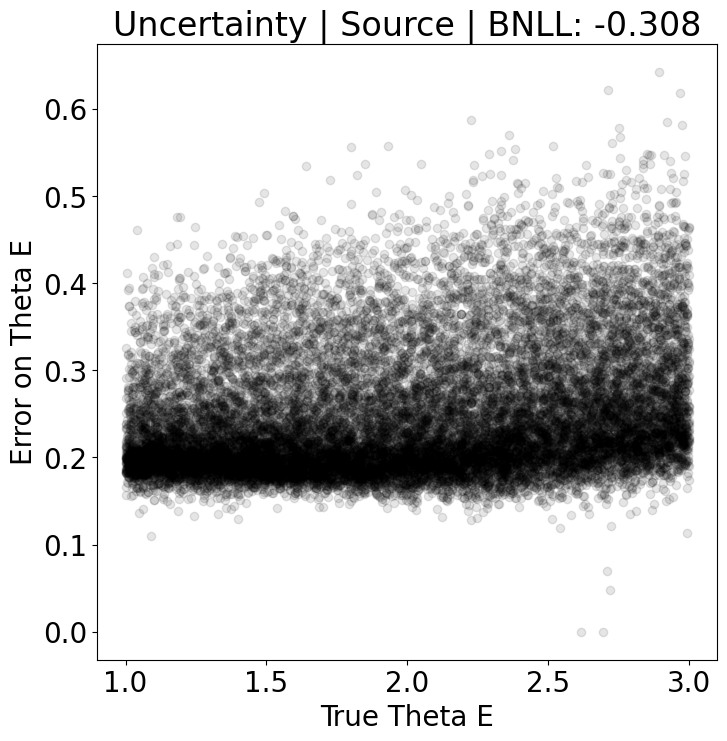

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [37]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9382


Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

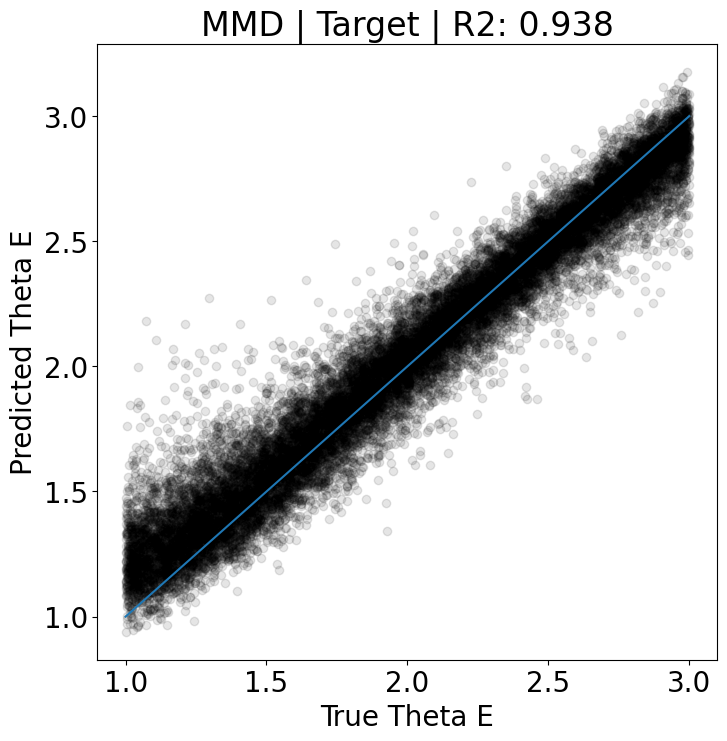

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

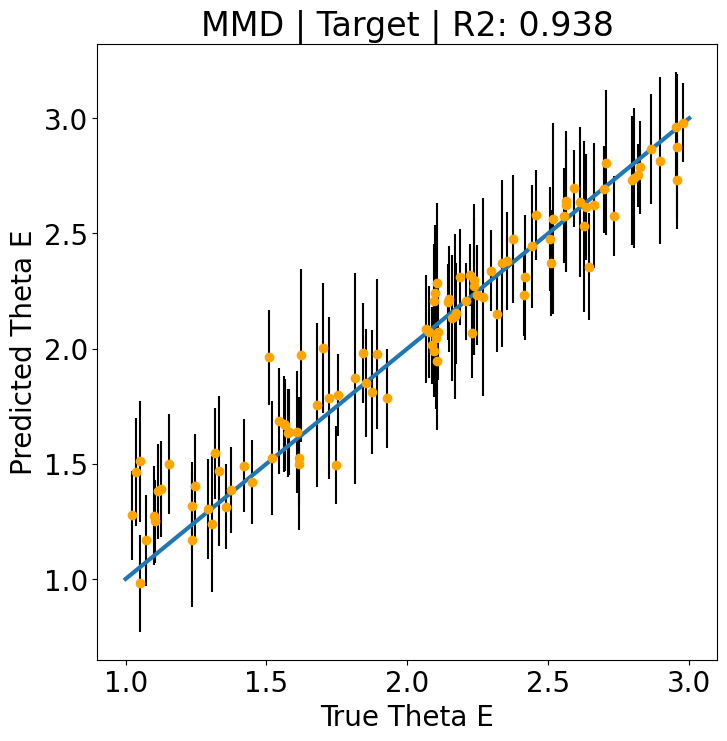

In [39]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.291')

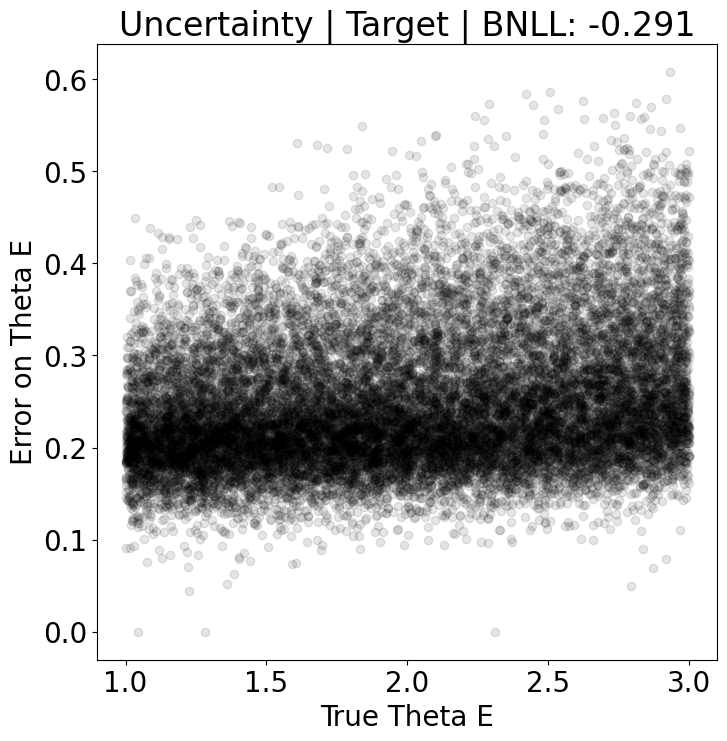

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [41]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

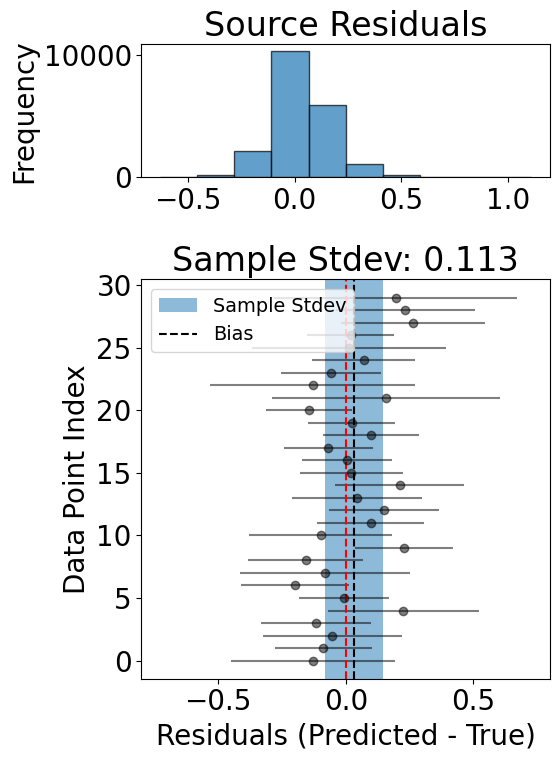

In [42]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

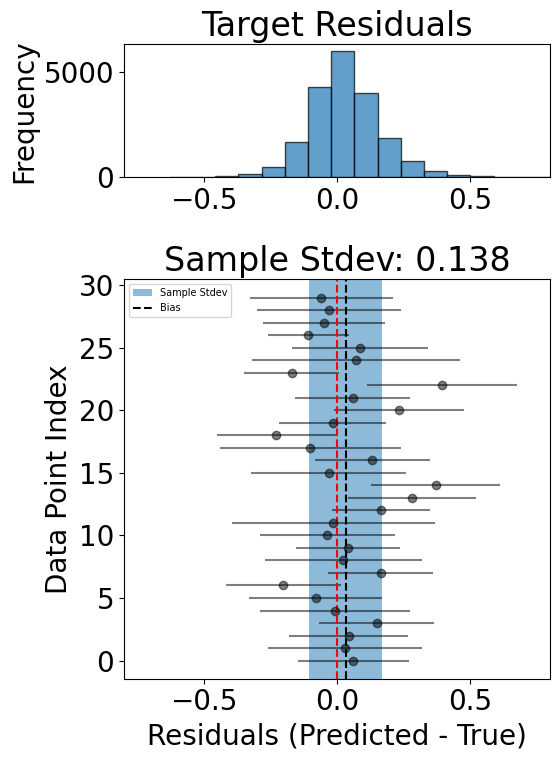

In [43]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()